In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.special import comb  # n choose k
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from collections import Counter

In [2]:
df = pd.read_csv('summary.csv')
df.head()

,subreddit,subscribers,current_users,creation_date,date_accessed,time_accessed_UTC,appearances
0,changemyview,1349762,1272,2013-01-16,2021-09-19,20:28:04,8
1,Terraform,19623,38,2012-06-05,2021-09-19,20:28:05,5
2,lostpause,78056,255,2015-04-07,2021-09-19,20:28:06,5
3,USPS,69497,568,2009-07-12,2021-09-19,20:28:07,4
4,MaliciousCompliance,1664837,5484,2016-01-04,2021-09-19,20:28:08,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subreddit          3678 non-null   object
 1   subscribers        3678 non-null   int64 
 2   current_users      3678 non-null   int64 
 3   creation_date      3678 non-null   object
 4   date_accessed      3678 non-null   object
 5   time_accessed_UTC  3678 non-null   object
 6   appearances        3678 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 201.3+ KB


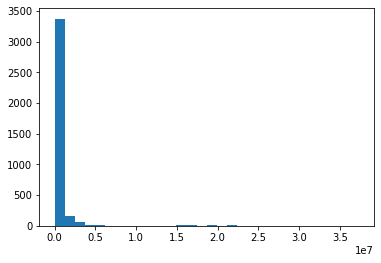

In [4]:
df['subscribers'].hist(bins=30,grid=False)
plt.show()

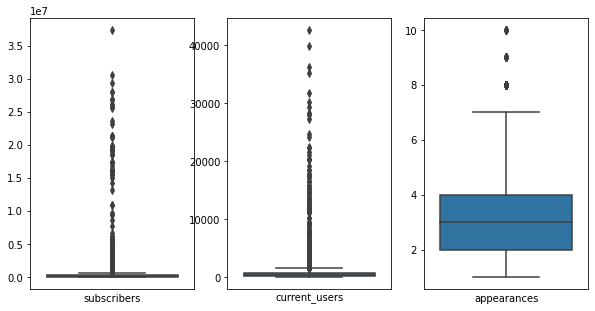

In [6]:
f, axs = plt.subplots(1,3)
f.set_size_inches(10,5)

for i, col in enumerate(['subscribers', 'current_users', 'appearances']):
  sns.boxplot(data=df[col], ax=axs[i])
  axs[i].set_xlabel(col)
  axs[i].set_xticks([])  # Clear the random 0 tick

plt.show()

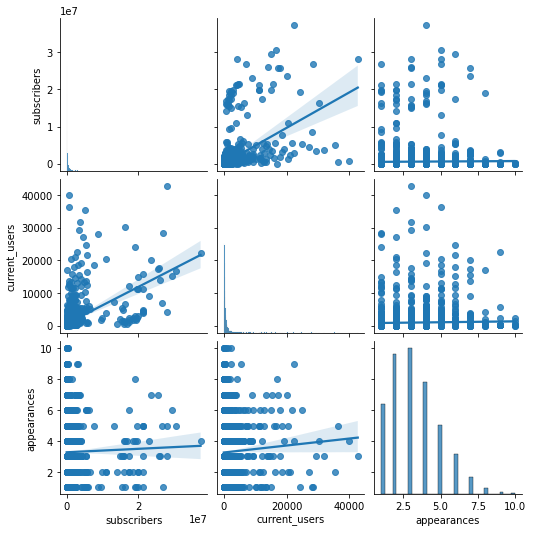

In [7]:
# Relationship between number of apperances and number of subscribers
sns.pairplot(data=df, kind='reg')
plt.show()
# Looks like there isn't really a relationship there



In [ ]:
# 3678 different results from 12_055 requests
# Is that a reasonable number of unique responses?
# considering we were sampling from a population of
# 3_108_788
# according to 
# https://frontpagemetrics.com/history/month
# and
# https://frontpagemetrics.com/list-all-subreddits
# which just happens to have created a list on september 17, 2021
# (two days before I did my thing)


In [8]:
# Expected number of K copies occuring when sampling with replacement
# https://math.stackexchange.com/questions/1056540/sampling-with-replacement-expected-number-of-duplicates-triplicates-n-t

# (m choose k) * (N-1) ** (m-k) / N ** (m-1)
#
# where 
# m = number of samples you take
# k = number of copies
# N = number of things in the population you're sampling

def expected_num_K_copies(m, k, N):
  # expected_num_K_copies(11, 4, 9)
  # returns 0.198481
  # So this at least matches the stackoverflow formula
  mCk = comb(m, k, exact=True)
  return mCk * ( (N-1) ** (m-k) / N ** (m-1) )



m = 12_055
N = 3_108_788

print('  k      Expected number of occurances')
for k in range(11):
  prob = expected_num_K_copies(m, k, N)
  print(f'  {k:<6}   {prob:>15.5f}')

# So basically nothing should show up more than twice


  k      Expected number of occurances
  0          3096756.34083
  1            12008.34849
  2               23.28056
  3                0.03009
  4                0.00003
  5                0.00000
  6                0.00000
  7                0.00000
  8                0.00000
  9                0.00000
  10               0.00000


In [9]:
df.loc[df['appearances'] > 2]
# annnnnnd I have 2318 that show up more than twice
# now we're getting somwhere

,subreddit,subscribers,current_users,creation_date,date_accessed,time_accessed_UTC,appearances
0,changemyview,1349762,1272,2013-01-16,2021-09-19,20:28:04,8
1,Terraform,19623,38,2012-06-05,2021-09-19,20:28:05,5
2,lostpause,78056,255,2015-04-07,2021-09-19,20:28:06,5
3,USPS,69497,568,2009-07-12,2021-09-19,20:28:07,4
4,MaliciousCompliance,1664837,5484,2016-01-04,2021-09-19,20:28:08,4
...,...,...,...,...,...,...,...
3579,tmobile,109567,1008,2011-05-17,2021-09-19,22:24:32,3
3581,l4d2,37234,141,2009-06-03,2021-09-19,22:24:34,3
3590,Archero,69592,252,2019-04-20,2021-09-19,22:24:42,3
3599,Acid,67215,241,2009-10-09,2021-09-19,22:24:51,3


In [142]:
# Check whether the K distribution thing lines up with reality

# Take a random sample w/ replacement from a known pool
# see whether it matches our prediction from expected_num_K_copies
N = 5000
m = 12000
samples = np.random.choice(N, size=m, replace=True)
c = Counter(samples)
c = Counter(c.values())
print('    Our sample  |  Our prediction |  Diff (rounded)')
total_diff = 0
for i in range(1, 20):
  real = c[i]
  pred = expected_num_K_copies(m, i, N)
  diff = round(pred - real)
  total_diff += diff
  print(f'{i:2} | {real:8}   |   {f"{pred:.2f}":>10}    |  {diff:>5} ')

print(f'\nTotal diff: {total_diff}')

    Our sample  |  Our prediction |  Diff (rounded)
 1 |     1113   |      1088.57    |    -24 
 2 |     1302   |      1306.44    |      4 
 3 |     1058   |      1045.19    |    -13 
 4 |      605   |       627.08    |     22 
 5 |      311   |       300.96    |    -10 
 6 |      118   |       120.36    |      2 
 7 |       35   |        41.25    |      6 
 8 |       17   |        12.37    |     -5 
 9 |        5   |         3.30    |     -2 
10 |        0   |         0.79    |      1 
11 |        0   |         0.17    |      0 
12 |        0   |         0.03    |      0 
13 |        0   |         0.01    |      0 
14 |        0   |         0.00    |      0 
15 |        0   |         0.00    |      0 
16 |        0   |         0.00    |      0 
17 |        0   |         0.00    |      0 
18 |        0   |         0.00    |      0 
19 |        0   |         0.00    |      0 

Total diff: -19


In [140]:
# what is the distribution in my data?
# 10 is the largest k
my_dist = []
for i in range(1, 11):
  my_dist.append(len(df.loc[df['appearances']==i]))

print(my_dist)

[533, 827, 857, 657, 406, 237, 101, 38, 14, 8]


In [15]:
def naive_dist_diff(dist1, dist2):
  """
  return the sum of the elementwise differences in the distributions

  e.g.
  [1, 2, 3, 4] 
  [5, 6, 7, 8]
  would be
  abs(1-5) + abs(2-6) + abs(3-7) + abs(4-8)
  = 4 + 4 + 4 + 4
  = 16
  """
  if len(dist1) != len(dist2):
    raise ValueError(f'Distributions must be the same length! Got {len(dist1)} and {len(dist2)} ')

  return np.sum(np.abs(np.array(dist1) - np.array(dist2)))


def gentle_dist_diff(dist1, dist2):
  """
  keep a running total of the elementwise differences in the distributions
  this way, positive and negative differences offset each other

  e.g.
  [5, 6, 7, 8]
  [1, 2, 3, 4] 
  would be
  (5-1) + (6-2) + (7-3) + (8-4)
  = 4 + 4 + 4 + 4
  = 16

  but
  [1, 6, 3, 8] 
  [5, 2, 7, 4]
  would be
  (1-5) + (6-2) + (3-7) + (8-4)
  = -4 + 4 + -4 + 4
  = 0
  """
  return np.sum(np.array(dist1) - np.array(dist2))


def build_k_dist(m, k, N):
  """
  runs `expected_num_k_copies(m, k, N)`
  for every value from 1 through k (inclusive)
  and returns the results as a list
  """
  dist = []
  for i in range(1, k+1):
    dist.append(expected_num_K_copies(m, i, N))
  return dist


def print_dict(d):
  for k,v in d.items():
    print(k, v)

In [20]:
# Go through a bunch of N values
# See which one is closest to my distribution

# Take big steps at first
# looks like we need to look smaller than
# 100_000
# smaller than 10_000
# minimum at 4_000

m = 12_055
end_k = 10

diffs = {}

for i in tqdm(range(1, int(1e4), int(1e3)), ascii=True):
  dist = build_k_dist(m, end_k, i)
  diffs[i] = naive_dist_diff(my_dist, dist)

print('\n')
print_dict(diffs)

100%|##########| 10/10 [00:00<00:00, 27.40it/s]



1 3678.0
1001 3725.7359123914985
2001 3032.854069774012
3001 1361.8747820271162
4001 241.81781932981858
5001 1561.2906513832263
6001 2706.386600472151
7001 3643.012030277227
8001 4408.108428993707
9001 5038.608341790433


In [18]:
# So they're getting picked from a pool of ballpark 4_000
# 
# explore that space a little more rigorously to get a 
# better sense of the size of it
def k_dist_from_pool(m, N, num_runs=10_000):
  """
  take m random samples with replacement from a pool of size N
  
  do that `runs` times

  calculate k dist thing I've been using 

  return the mean of those runs
  """
  k = 10
  runs = []
  for i in range(num_runs):
    # m random samples with replacement from N
    samples = np.random.choice(N, size=m, replace=True)
    # trickyness to get the number of occurances we're looking for
    counts = Counter(Counter(samples).values())
    # Record the results of that run
    single_run = []
    for j in range(1, k+1):
      if j in counts.keys():
        single_run.append(counts[j])
      else:
        single_run.append(0)
    runs.append(single_run)

  return np.mean(runs, axis=0)


print(k_dist_from_pool(500, 100))
print(expected_num_K_copies(500, 2, 100))



[ 3.3239  8.3369 14.081  17.576  17.5995 14.6735 10.4953  6.559   3.6059
  1.7562]
8.363103352119431


In [21]:
# This might be data mining
# but look for the value of N
# that gives a k distribution
# that's closest to my distribution

m = 12_055

search_start = 3000
search_end = 5000
step_size = 5
diffs = []
gentle_diffs = []
for N in tqdm(range(search_start, search_end, step_size), ascii=True):
  dist = k_dist_from_pool(m, N, num_runs=100)
  diffs.append(naive_dist_diff(my_dist, dist))
  gentle_diffs.append(gentle_dist_diff(my_dist, dist))


100%|##########| 400/400 [01:53<00:00,  3.52it/s]


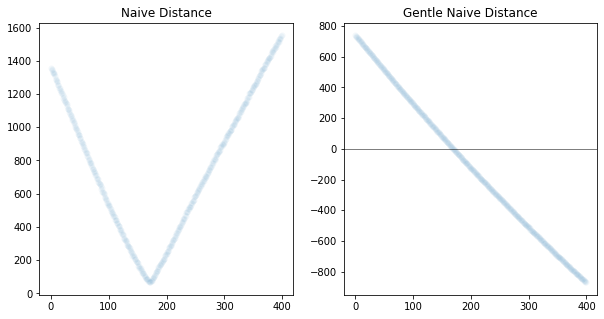

In [22]:
# Compare the two distance functions I used
# They look like they give the same answer
#
# might be easier to fit a linear regression to the gentle one
# instead of fitting absolute value to the normal one

f, axs = plt.subplots(1,2)
f.set_size_inches((10,5))
sns.scatterplot(x=list(range(len(diffs))), y=diffs, alpha=0.05, ax=axs[0])
axs[0].set_title('Naive Distance')
sns.scatterplot(x=list(range(len(gentle_diffs))), y=gentle_diffs, alpha=0.05, ax=axs[1])
axs[1].axhline(0, color='k', lw=0.5)
axs[1].set_title('Gentle Naive Distance')
plt.show()

In [27]:
arg_min = np.argmin(np.array(diffs))
print(f'Pool size guess (argmin): {step_size * arg_min + search_start}')

Pool size guess (argmin): 3855


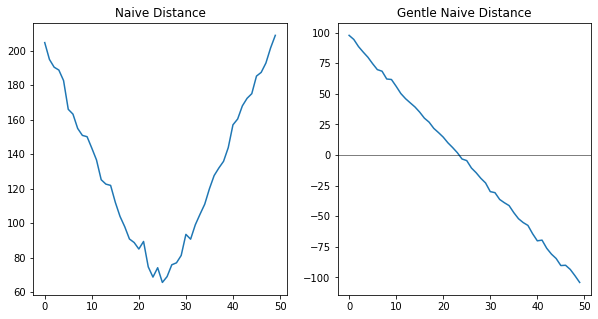

In [31]:
zoomed_diffs = diffs[arg_min-25:arg_min+25]
zoomed_gentle_diffs = gentle_diffs[arg_min-25:arg_min+25]
zoomed_x = list(range(len(zoomed_diffs)))

f, axs = plt.subplots(1,2)
f.set_size_inches((10,5))

sns.lineplot(x=zoomed_x, y=zoomed_diffs, ax=axs[0])
axs[0].set_title('Naive Distance')
sns.lineplot(x=zoomed_x, y=zoomed_gentle_diffs, ax=axs[1])
axs[1].axhline(0, color='k', lw=0.5)
axs[1].set_title('Gentle Naive Distance')
plt.show()
# pretty noisy

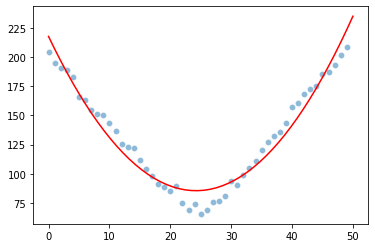

In [32]:
# fit a quadratic to the zoomed diffs
coefs = np.polyfit(list(range(len(zoomed_diffs))), zoomed_diffs, deg=2)
fit = np.poly1d(coefs)
fit_xs = np.linspace(0, len(zoomed_diffs), 50)
fit_ys = [fit(i) for i in fit_xs]

sns.scatterplot(x=list(range(len(zoomed_diffs))), y=zoomed_diffs, alpha=0.5)
sns.lineplot(x=fit_xs, y=fit_ys, color='red')
plt.show()
# that looks pretty good
# I think it should be a bit sharper
# increasing the degree to 3 doesn't change the answer
# 4 changes it
# shifts it to the right a bit
# I think that's closer to what I want
# fits the important middle curve better
# even though it's much worse on the ends
#
# Not that any of that is relevant at all
# no reason to pick degree 4, so prefer the
# simpler degree 2
#
# Best would probably be to fit the absolute value function

In [36]:
# Find the minimum of that fit line
fit_min = np.array(fit_ys).argmin()

# arg_min - 25 because the zoomed diffs start there 
pool_size_est = fit_min + search_start + (arg_min*step_size) - (25 * step_size)
print(f'Pool size guess (Quadratic fit): {pool_size_est}')
# 3856
# My final answer for the size of the pool 
# that they pick random subreddits from is 4000
#
# I suppose I could've just guessed the number of subs I saw
# 3678

Pool size guess (Quadratic fit): 3754


[  5.92139231  24.31703627 -58.29839617]


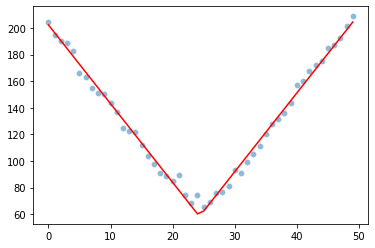

In [38]:
# Fit the absolute value function to the zoomed data
def abs_func(x, b1, b2, b3):
  # b1: change the angle between then two legs
  # b2: change the x position of the vertex
  # b3: change the y position of the vertex
  #
  # maybe there's a way to change the angles of the legs independently
  # maybe make it piecewise or something
  # 
  return b1 * np.abs(x - b2) - b3

abs_x = list(range(len(zoomed_diffs)))

params, _ = curve_fit(abs_func, abs_x, zoomed_diffs, p0=[1.3, 25, -45])
print(params)


sns.scatterplot(x=abs_x, y=zoomed_diffs, alpha=0.5)
sns.lineplot(x=abs_x, y=[abs_func(x, *params) for x in abs_x], color='red')
plt.show()

# Seems a little too far to the right
# probably a better fit than the quadratic though
#
# TODO: check fit metrics of quadratic vs abs

In [44]:
abs_guess = round(params[1] * step_size + search_start + (arg_min*step_size) - (25 * step_size))
print(f"Pool size guess (abs() fit): {abs_guess}")
# This looks spot on

Pool size guess (abs() fit): 3852


Pool size guess (linear fit): 4248


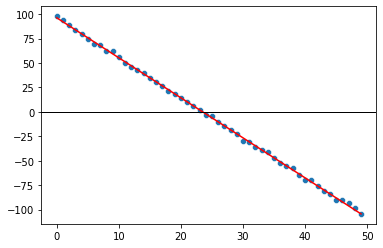

In [153]:
# Fit a linear regression to the gentle distance data
gentle_x = list(range(len(zoomed_gentle_diffs)))

lm = LinearRegression().fit(np.array(gentle_x).reshape(-1,1), 
                            np.array(zoomed_gentle_diffs).reshape(-1,1))

gentle_preds = lm.predict(np.array(gentle_x).reshape(-1,1)).ravel()

# solve for the 0
# 0 = intercept + b1*x
# intercept = -b1*x
# x = intercept / -b1

lm_zero = float(lm.intercept_) / ( 0 - float(lm.coef_[0]) )
lm_guess = round(lm_zero * step_size + search_start + (arg_min*step_size) - (25 * step_size))
print(f'Pool size guess (linear fit): {lm_guess}')

sns.scatterplot(x=gentle_x, y=zoomed_gentle_diffs)
sns.lineplot(x=gentle_x, y=gentle_preds, color='red')
plt.axhline(0, lw=1, color='k')
plt.show()


In [46]:
# Check my work a bit
# Hypothesis:
# they pull from the 5000 largest subs
# 
# test:
# do any of my subs have subscriber counts outside of the top 5000?

# Happened to notice USPS at number 4901 in the list of
# top subreddits, and I know that was in my results
# I think top 5000 is a decent guess
# I'm not sure why it differs from the expected number
# of k repeats so much though
# Maybe I need to use an actual distance metric 
# rather than my own homecooked thing

# https://frontpagemetrics.com/top-sfw-subreddits/offset/4900
# 5000th subreddit as of October 18, 2021 has
# 68_604 subscribers
#
# I might be in trouble since I've put this off for so long
df.loc[df['subscribers'] < 68_604].sort_values(by='appearances', ascending=False)

# 1314 results

# Terraform only has 19_623
# and it showed up 5 times

# viralphotoleaks
# 141 subscribers
# 10 appearances

# maybe it's some linear combination of factors
# like subscribers / days since creation
# or something


# I guess I could redo the scraping and see whether it's the same results
# My new idea is that they create of pool of 5000 ish to pull from 
# and then change that pool every so often

# Can't really afford another scraping session though
# I want to write the blog post and move on to another project



,subreddit,subscribers,current_users,creation_date,date_accessed,time_accessed_UTC,appearances
1538,Noom,30535,148,2015-11-18,2021-09-19,21:02:09,10
2256,ROBLOXExploiting,6978,44,2018-04-28,2021-09-19,21:13:10,10
1118,viralphotoleaks,141,45,2021-08-31,2021-09-19,20:55:48,10
2021,Optifine,52330,112,2013-10-09,2021-09-19,21:09:36,9
1113,madnesscombat,19908,319,2010-10-02,2021-09-19,20:55:44,9
...,...,...,...,...,...,...,...
1267,CPA,26827,183,2010-03-18,2021-09-19,20:58:04,1
3158,AskSF,45462,270,2013-10-28,2021-09-19,22:18:13,1
2664,NCT,34215,172,2014-08-21,2021-09-19,21:19:23,1
3168,algorand,38751,428,2017-04-27,2021-09-19,22:18:21,1


In [48]:
# bootstrap CI
#
# just to refresh my memory
# my_dist
# [533, 827, 857, 657, 406, 237, 101, 38, 14, 8]

my_pool_size_guess = 3850

bootstrap_runs = 10_000
bootstrap_dists = [None] * bootstrap_runs
for i in tqdm(range(bootstrap_runs), ascii=True):
  bootstrap_dists[i] = k_dist_from_pool(12_055, my_pool_size_guess, num_runs=1)

100%|##########| 10000/10000 [00:28<00:00, 345.91it/s]


In [66]:
# Sort each k duplicate individually
sorted_dists = np.array(bootstrap_dists).transpose()
sorted_dists.sort(axis=-1)
# print(sorted_dists)

# take the 1st, 5th, 50th, 95th and 99th percentile
# for each k duplicate
firsts = []
fifths = []
medians = []
ninetyfifths = []
ninetyninths = []
first_idx = (bootstrap_runs // 100 )
fifth_idx = (bootstrap_runs // 100 ) * 5
median_idx = bootstrap_runs // 2
ninetyfifth_idx = (bootstrap_runs // 100) * 95
ninetyninth_idx = (bootstrap_runs // 100 ) * 99
for k in range(10):
  firsts.append(sorted_dists[k, first_idx])
  fifths.append(sorted_dists[k, fifth_idx])
  medians.append(sorted_dists[k, median_idx])
  ninetyfifths.append(sorted_dists[k, ninetyfifth_idx])
  ninetyninths.append(sorted_dists[k, ninetyninth_idx])

print(f'{firsts}')
print(f'{fifths}')
print(f'{medians}')
print(f'{ninetyfifths}')
print(f'{ninetyninths}')


[483.0, 768.0, 801.0, 620.0, 380.0, 190.0, 78.0, 25.0, 6.0, 0.0]
[496.0, 785.0, 818.0, 636.0, 393.0, 198.0, 84.0, 29.0, 8.0, 1.0]
[527.0, 824.0, 860.0, 673.0, 422.0, 220.0, 98.0, 38.0, 13.0, 4.0]
[557.0, 864.0, 904.0, 711.0, 452.0, 242.0, 114.0, 49.0, 19.0, 8.0]
[570.0, 879.0, 921.0, 725.0, 464.0, 251.0, 121.0, 53.0, 22.0, 10.0]


In [69]:

errs_95

array([[30., 40., 44., 38., 30., 22., 16., 11.,  6.,  4.],
       [31., 39., 42., 37., 29., 22., 14.,  9.,  5.,  3.]])

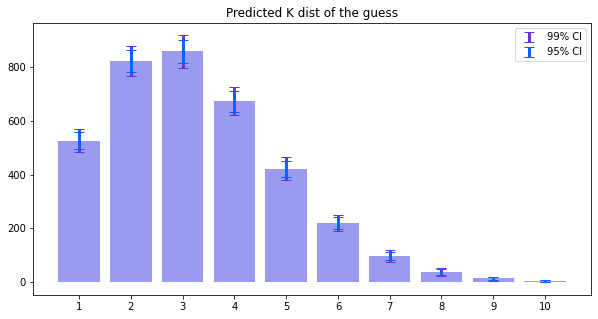

In [109]:
upper_errs_95 = np.array(ninetyfifths) - np.array(medians)
lower_errs_95 = np.array(medians) - np.array(fifths)
errs_95 = np.array([upper_errs_95, lower_errs_95])

upper_errs_99 = np.array(ninetyninths) - np.array(medians)
lower_errs_99 = np.array(medians) - np.array(firsts)
errs_99 = np.array([upper_errs_99, lower_errs_99])

plt.figure().set_size_inches(10,5)

sns.barplot(x=list(range(1,11)), y=medians, alpha=0.45, color='blue')
plt.errorbar(x=list(range(10)), y=medians, yerr=errs_99, 
             fmt='none',
             ecolor='xkcd:burple',
             elinewidth=3,
             capsize=5,
             label='99% CI')
plt.errorbar(x=list(range(10)), y=medians, yerr=errs_95, 
             fmt='none',
             ecolor='xkcd:bright blue',
             elinewidth=3,
             capsize=5,
             label='95% CI')




plt.title('Predicted K dist of the guess')
plt.legend()
plt.show()
# It looks really bad with both error bars

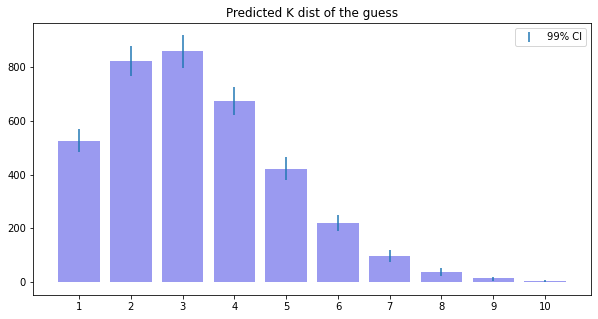

In [111]:
upper_errs_99 = np.array(ninetyninths) - np.array(medians)
lower_errs_99 = np.array(medians) - np.array(firsts)
errs_99 = np.array([upper_errs_99, lower_errs_99])

plt.figure().set_size_inches(10,5)


sns.barplot(x=list(range(1,11)), y=medians, alpha=0.45, color='blue')
plt.errorbar(x=list(range(10)), y=medians, yerr=errs_99, fmt='none', label='99% CI')


plt.title('Predicted K dist of the guess')
plt.legend()
plt.show()

In [ ]:
# next:
# run the same curve fitting thing for the upper and lower bound
# then that will give me a bootstrapped confidence interval
# for my pool size estimate
# roughly
# possibly with some circular logic
# but it's better than nothing, I think

In [121]:
# search the same area
m = 12_055
search_start = 3000
search_end = 5000
step_size = 5
diffs_99 = []
diffs_1 = []
for N in tqdm(range(search_start, search_end, step_size), ascii=True):
  dist = k_dist_from_pool(m, N, num_runs=100)
  diffs_99.append(gentle_dist_diff(ninetyninths, dist))
  diffs_1.append(gentle_dist_diff(firsts, dist))

100%|##########| 400/400 [01:53<00:00,  3.53it/s]


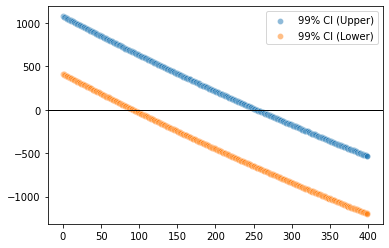

In [127]:
# fit the linear one again
# boot_ci_x = list(range(len(diffs_99)))

# lm_99 = LinearRegression().fit(np.array(boot_ci_x).reshape(-1,1), 
#                                np.array(diffs_99).reshape(-1,1))
# preds_99 = lm_99.predict(np.array(boot_ci_x).reshape(-1,1)).ravel()

# lm_1 = LinearRegression().fit(np.array(boot_ci_x).reshape(-1,1), 
#                                np.array(diffs_1).reshape(-1,1))
# preds_1 = lm_1.predict(np.array(boot_ci_x).reshape(-1,1)).ravel()

sns.scatterplot(x=boot_ci_x, y=diffs_99, alpha=0.5, label='99% CI (Upper)')
sns.scatterplot(x=boot_ci_x, y=diffs_1, alpha=0.5, label='99% CI (Lower)')
plt.axhline(0, lw=1, color='k')
plt.show()

# Looks like we're going to have to do each one individually

100%|##########| 40/40 [00:12<00:00,  3.30it/s]



Upper bound of 99% CI: 4271



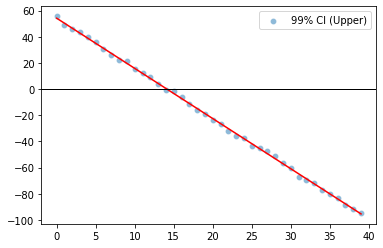

In [131]:
# Upper bound search
m = 12_055
search_start = 4200
search_end = 4400
step_size = 5
diffs_99 = []
for N in tqdm(range(search_start, search_end, step_size), ascii=True):
  dist = k_dist_from_pool(m, N, num_runs=100)
  diffs_99.append(gentle_dist_diff(ninetyninths, dist))


boot_ci_x = list(range(len(diffs_99)))

lm_99 = LinearRegression().fit(np.array(boot_ci_x).reshape(-1,1), 
                               np.array(diffs_99).reshape(-1,1))
preds_99 = lm_99.predict(np.array(boot_ci_x).reshape(-1,1)).ravel()

zero_99 = float(lm_99.intercept_) / ( 0 - float(lm_99.coef_[0]) )
guess_99 = round(zero_99 * step_size + search_start)
print(f'\nUpper bound of 99% CI: {guess_99}\n')

sns.scatterplot(x=boot_ci_x, y=diffs_99, alpha=0.5, label='99% CI (Upper)')
sns.lineplot(x=boot_ci_x, y=preds_99, color='red')
plt.axhline(0, lw=1, color='k')
plt.show()


100%|##########| 40/40 [00:11<00:00,  3.54it/s]



Lower bound of 99% CI: 3461



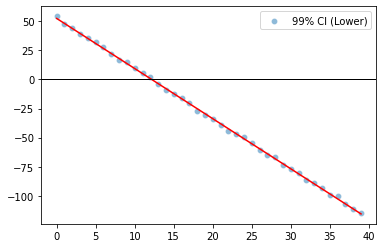

In [133]:
# Lower bound search
m = 12_055
search_start = 3400
search_end = 3600
step_size = 5
diffs_1 = []
for N in tqdm(range(search_start, search_end, step_size), ascii=True):
  dist = k_dist_from_pool(m, N, num_runs=100)
  diffs_1.append(gentle_dist_diff(firsts, dist))


boot_ci_x = list(range(len(diffs_1)))

lm_1 = LinearRegression().fit(np.array(boot_ci_x).reshape(-1,1), 
                               np.array(diffs_1).reshape(-1,1))
preds_1 = lm_1.predict(np.array(boot_ci_x).reshape(-1,1)).ravel()

zero_1 = float(lm_1.intercept_) / ( 0 - float(lm_1.coef_[0]) )
guess_1 = round(zero_1 * step_size + search_start)
print(f'\nLower bound of 99% CI: {guess_1}\n')

sns.scatterplot(x=boot_ci_x, y=diffs_1, alpha=0.5, label='99% CI (Lower)')
sns.lineplot(x=boot_ci_x, y=preds_1, color='red')
plt.axhline(0, lw=1, color='k')
plt.show()



In [ ]:
# So, final answer:
# The size of the pool is between 3461 and 4271 with 99% confidence
# based on a guess of 3850